In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})
import numpy as np

In [2]:
import lmfit

In [84]:
filename = "/Users/spx8sk/Downloads/phase220.dat"

In [170]:
x, y = np.loadtxt(filename, unpack=True)

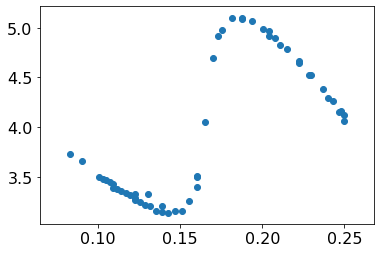

In [171]:
plt.figure()
plt.scatter(x, y)

In [172]:
ymean = np.mean(y)

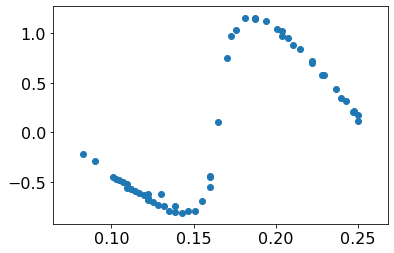

In [173]:
plt.figure()
plt.scatter(x, y-ymean)

In [188]:
ydiff = np.diff(y)
xnew = np.array(range(len(ydiff)))

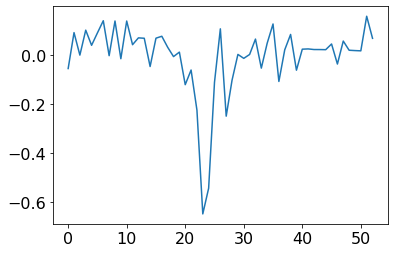

In [189]:
plt.figure()
plt.plot(xnew, ydiff)

In [296]:
from lmfit.models import LinearModel, LorentzianModel, GaussianModel, PowerLawModel, ExponentialModel

# peak = LorentzianModel()
peak = GaussianModel()

# mask = (xnew>15) & (xnew<30)
mask = (xnew>10) & (xnew<40)

pars = peak.guess(ydiff[mask], x=xnew[mask])


# background = LinearModel()
# background = PowerLawModel(prefix='pl_')
background = ExponentialModel(prefix='pl_')


bpars = background.guess(ydiff, x=xnew)
# bpars = background.make_params(pl_amplitude=0.000001, pl_decay=-0.001 )

pars.update(bpars)

model = peak + background

In [297]:
pars

Parameters([('amplitude',
             <Parameter 'amplitude', value=32.49031413456998, bounds=[-inf:inf]>),
            ('center',
             <Parameter 'center', value=25.11111111111111, bounds=[-inf:inf]>),
            ('sigma', <Parameter 'sigma', value=14.0, bounds=[0.0:inf]>),
            ('fwhm',
             <Parameter 'fwhm', value=32.96748, bounds=[-inf:inf], expr='2.3548200*sigma'>),
            ('height',
             <Parameter 'height', value=0.9258400463262755, bounds=[-inf:inf], expr='0.3989423*amplitude/max(2.220446049250313e-16, sigma)'>),
            ('pl_amplitude',
             <Parameter 'pl_amplitude', value=0.045815071181199894, bounds=[-inf:inf]>),
            ('pl_decay',
             <Parameter 'pl_decay', value=601.890551822019, bounds=[-inf:inf]>)])

In [298]:
fit = model.fit(ydiff, pars, x=xnew)

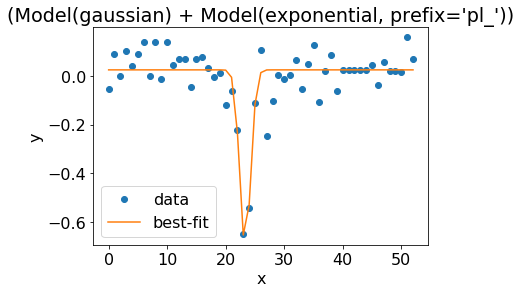

In [299]:
fit.plot_fit()

In [300]:
best_fit = model.eval(fit.params, x=xnew)

In [301]:
import scipy
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
def compute_integral(times, x, npts=None):
    """
    times = array of independent variable
    x = array of dependent variable
    npts = None (default to len(times)) number o fpoints to resample to integrate
    """
    
    if npts is None:
        npts = len(times)*2

    ix = IUS(times,  x)

    t1 = times[0]
    t2 = times[-1]
    res = []
    dt = times[1] - times[0]
    tss = np.linspace(t1+dt, t2, npts)
    for ts in tss: 
        res.append(scipy.integrate.quad(ix, t1, ts)[0])
    res = np.array(res)

    ires = IUS(tss, res)
    return ires(times)

In [302]:
best_fit_int = compute_integral(xnew, best_fit)

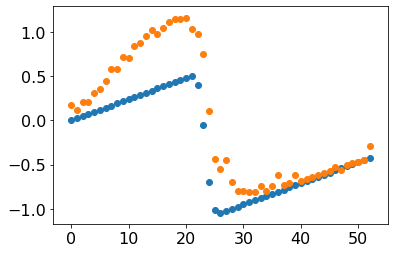

In [303]:
plt.figure()
plt.scatter(xnew, best_fit_int)
plt.scatter(xnew, (y-ymean)[:-1])

In [87]:
def ansatz(x, A, x0, tau, c):
    return A * np.exp(-(x-x0)/tau) + c

In [108]:
# data to fit
x1 = 0.01
x2 = 0.14

mask = (x>=x1) & (x<=x2)
x_fit = x[mask]
y_fit = y[mask]

model = lmfit.Model(ansatz)

model.set_param_hint('A', value=0.1)
model.set_param_hint('x0', value=0.8)
model.set_param_hint('tau', value=0.2)
model.set_param_hint('c', value=0.2)

p = model.make_params()

In [111]:
result = model.fit(data=y_fit, x=x_fit, params=p, method='Nelder')
# result = model.fit(data=y_fit, x=x_fit, params=p)

In [112]:
lmfit.report_fit(result)

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 195
    # data points      = 22
    # variables        = 4
    chi-square         = 0.02320762
    reduced chi-square = 0.00128931
    Akaike info crit   = -142.794974
    Bayesian info crit = -138.430804
##  Warning: uncertainties could not be estimated:
[[Variables]]
    A:    0.28840333 +/- 0.43391085 (150.45%) (init = 0.1)
    x0:   0.99255096 +/-        nan (nan%) (init = 0.8)
    tau:  0.35463901 +/-        nan (nan%) (init = 0.2)
    c:   -0.06155098 +/-        nan (nan%) (init = 0.2)


(<Figure size 432x432 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

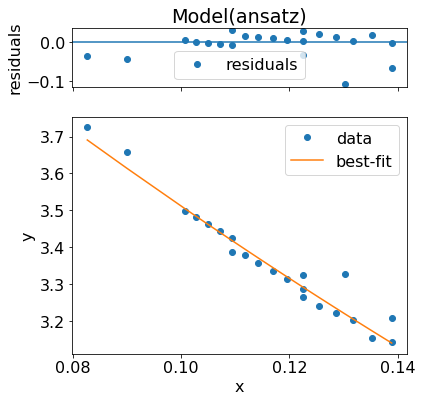

In [113]:
result.plot()

In [69]:
def ansatz_peak(x, A, x0, tau, a1, a2, x1, c):
    sech = 1./np.cosh((x-x0)/tau) * A
    return sech**2 + a1*np.exp(-(x-x1)/a2) + c

In [166]:
# data to fit
x1 = 0.16
x2 = 0.25

mask = (x>=x1) & (x<=x2)
x_fit = x[mask]
y_fit = y[mask]

model = lmfit.Model(ansatz_peak)

model.set_param_hint('A', value=2.1)
model.set_param_hint('x0', value=0.3)
model.set_param_hint('tau', value=-14)

model.set_param_hint('a1', value=-64)
model.set_param_hint('a2', value=30)
model.set_param_hint('x1', value=41)

model.set_param_hint('c', value=48)

p = model.make_params()

In [167]:
# result = model.fit(data=y_fit, x=x_fit, params=p, method='Nelder', nan_policy='omit')
result = model.fit(data=y_fit, x=x_fit, params=p, method='least_squares', nan_policy='omit')

In [168]:
lmfit.report_fit(result)

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 700
    # data points      = 28
    # variables        = 7
    chi-square         = 1.73325186
    reduced chi-square = 0.08253580
    Akaike info crit   = -63.9017451
    Bayesian info crit = -54.5763135
##  Warning: uncertainties could not be estimated:
[[Variables]]
    A:    21.2740052 +/- 3097.39145 (14559.51%) (init = 2.1)
    x0:   0.18712110 +/- 5.37830368 (2874.24%) (init = 0.3)
    tau: -0.88874394 +/- 129.597442 (14582.09%) (init = -14)
    a1:  -67.5271744 +/-        nan (nan%) (init = -64)
    a2:   23.6617821 +/- 49897.1222 (210876.43%) (init = 30)
    x1:   47.2487931 +/-        nan (nan%) (init = 41)
    c:    45.7347222 +/- 1039314.21 (2272483.94%) (init = 48)
[[Correlations]] (unreported correlations are < 0.100)
    C(A, tau)  = -1.000
    C(a2, c)   =  0.999
    C(A, x0)   = -0.950
    C(x0, tau) =  0.950
    C(tau, a2) =  0.123
    C(x0, a2)  =  0.123
    C(A, a2)   = -0.118
    C(ta

(<Figure size 432x432 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

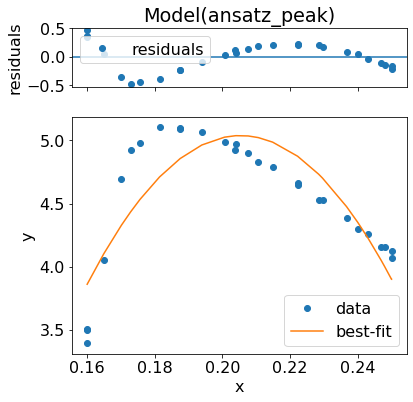

In [169]:
result.plot()